In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader
import numpy as np

In [2]:
class Matryoshka_CE_Loss(nn.Module):
    def __init__(self, relative_importance=None, **kwargs):
        super(Matryoshka_CE_Loss, self).__init__()
        self.criterion = nn.CrossEntropyLoss(**kwargs)
        self.relative_importance = relative_importance

    def forward(self, output, target):
        losses = torch.stack([self.criterion(output_i, target) for output_i in output])
        rel_importance = torch.ones_like(losses) if self.relative_importance is None else torch.as_tensor(self.relative_importance, device=losses.device).clone().detach()        
        weighted_losses = rel_importance * losses
        return weighted_losses.sum()

class MRL_Linear_Layer(nn.Module):
    def __init__(self, nesting_list, num_classes=100, efficient=False, **kwargs):
        super(MRL_Linear_Layer, self).__init__()
        self.nesting_list = nesting_list
        self.num_classes = num_classes
        self.efficient = efficient
        if self.efficient:
            self.nesting_classifier_0 = nn.Linear(nesting_list[-1], self.num_classes, **kwargs)
        else:
            for i, num_feat in enumerate(self.nesting_list):
                setattr(self, f"nesting_classifier_{i}", nn.Linear(num_feat, self.num_classes, **kwargs))

    def forward(self, x):
        nesting_logits = ()
        for i, num_feat in enumerate(self.nesting_list):
            if self.efficient:
                if self.nesting_classifier_0.bias is None:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()), )
                else:
                    nesting_logits += (torch.matmul(x[:, :num_feat], (self.nesting_classifier_0.weight[:, :num_feat]).t()) + self.nesting_classifier_0.bias, )
            else:
                nesting_logits += (getattr(self, f"nesting_classifier_{i}")(x[:, :num_feat]),)
        return nesting_logits
        

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [4]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761)),
])

train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False, num_workers=1)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# тут меняется размер фиксированного слоя
nesting_list = [128]
relative_importance = [1.0]
relative_importance_tensor = torch.tensor(relative_importance, device=device)
model = resnet18(weights=None)
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model.fc = MRL_Linear_Layer(nesting_list, num_classes=100, efficient=False)
model = model.to(device)

In [6]:
def train(epoch):
    model.train()
    train_loss = 0
    correct = {n: 0 for n in nesting_list}
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for i, n in enumerate(nesting_list):
            _, predicted = outputs[i].max(1)
            correct[n] += predicted.eq(targets).sum().item()
        total += targets.size(0)

    avg_acc = 100. * sum(correct.values()) / (total * len(nesting_list))
    print(f"| {'Train':^6} {epoch:^3} | Loss: {train_loss/((batch_idx+1) * len(nesting_list)):^7.3f} | Acc: {avg_acc:^6.3f}% |")

In [7]:
def test(epoch):
    model.eval()
    test_loss = 0
    correct_top1 = {n: 0 for n in nesting_list}
    correct_top5 = {n: 0 for n in nesting_list}
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            
            for i, n in enumerate(nesting_list):
                _, predicted = outputs[i].max(1)
                correct_top1[n] += predicted.eq(targets).sum().item()
                
                _, top5_pred = outputs[i].topk(5, 1, True, True)
                correct_top5[n] += top5_pred.eq(targets.view(-1, 1)).sum().item()
            
            total += targets.size(0)

    avg_top1 = sum(100. * correct_top1[n] / total for n in nesting_list) / len(nesting_list)
    avg_top5 = sum(100. * correct_top5[n] / total for n in nesting_list) / len(nesting_list)
    
    print("\n┌──────────┬────────────┬────────────┐")
    print(f"│ {'Size':^8} │ {'Top-1 Acc':^10} │ {'Top-5 Acc':^10} │")
    print("├──────────┼────────────┼────────────┤")
    
    for n in nesting_list:
        top1 = 100. * correct_top1[n] / total
        top5 = 100. * correct_top5[n] / total
        print(f"│ {n:^8} │ {top1:>9.2f}% │ {top5:>9.2f}% │")
    
    print("├──────────┼────────────┼────────────┤")
    print(f"│ {'Average':^8} │ {avg_top1:>9.2f}% │ {avg_top5:>9.2f}% │")
    print("└──────────┴────────────┴────────────┘")
    
    return avg_top1 

In [8]:
criterion = Matryoshka_CE_Loss(relative_importance=relative_importance_tensor)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

| Train   0  | Loss:  3.733  | Acc: 12.168% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     18.45% │     46.91% │
├──────────┼────────────┼────────────┤
│ Average  │     18.45% │     46.91% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   1  | Loss:  3.075  | Acc: 22.960% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     27.13% │     59.88% │
├──────────┼────────────┼────────────┤
│ Average  │     27.13% │     59.88% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train   2  | Loss:  2.693  | Acc: 30.702% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  20  | Loss:  1.548  | Acc: 56.546% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     51.23% │     80.68% │
├──────────┼────────────┼────────────┤
│ Average  │     51.23% │     80.68% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  21  | Loss:  1.528  | Acc: 56.842% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     51.31% │     80.12% │
├──────────┼────────────┼────────────┤
│ Average  │     51.31% │     80.12% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  22  | Loss:  1.520  | Acc: 57.036% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  40  | Loss:  1.366  | Acc: 61.244% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     55.05% │     82.92% │
├──────────┼────────────┼────────────┤
│ Average  │     55.05% │     82.92% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  41  | Loss:  1.351  | Acc: 61.420% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     51.41% │     80.85% │
├──────────┼────────────┼────────────┤
│ Average  │     51.41% │     80.85% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  42  | Loss:  1.356  | Acc: 61.410% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  60  | Loss:  1.218  | Acc: 64.530% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     54.09% │     82.01% │
├──────────┼────────────┼────────────┤
│ Average  │     54.09% │     82.01% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  61  | Loss:  1.207  | Acc: 65.062% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     52.88% │     81.92% │
├──────────┼────────────┼────────────┤
│ Average  │     52.88% │     81.92% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  62  | Loss:  1.200  | Acc: 65.316% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  80  | Loss:  1.068  | Acc: 68.622% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     59.95% │     85.87% │
├──────────┼────────────┼────────────┤
│ Average  │     59.95% │     85.87% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  81  | Loss:  1.047  | Acc: 69.190% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     58.39% │     84.47% │
├──────────┼────────────┼────────────┤
│ Average  │     58.39% │     84.47% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  82  | Loss:  1.041  | Acc: 69.258% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  100 | Loss:  0.867  | Acc: 74.006% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     59.78% │     86.05% │
├──────────┼────────────┼────────────┤
│ Average  │     59.78% │     86.05% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  101 | Loss:  0.853  | Acc: 74.244% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     60.02% │     85.89% │
├──────────┼────────────┼────────────┤
│ Average  │     60.02% │     85.89% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  102 | Loss:  0.844  | Acc: 74.538% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  120 | Loss:  0.634  | Acc: 80.562% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     62.35% │     86.82% │
├──────────┼────────────┼────────────┤
│ Average  │     62.35% │     86.82% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  121 | Loss:  0.616  | Acc: 81.024% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     58.95% │     84.37% │
├──────────┼────────────┼────────────┤
│ Average  │     58.95% │     84.37% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  122 | Loss:  0.607  | Acc: 81.256% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  140 | Loss:  0.349  | Acc: 88.912% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     64.65% │     87.78% │
├──────────┼────────────┼────────────┤
│ Average  │     64.65% │     87.78% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  141 | Loss:  0.343  | Acc: 89.024% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     64.11% │     87.36% │
├──────────┼────────────┼────────────┤
│ Average  │     64.11% │     87.36% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  142 | Loss:  0.327  | Acc: 89.588% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  160 | Loss:  0.100  | Acc: 97.140% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     67.90% │     89.00% │
├──────────┼────────────┼────────────┤
│ Average  │     67.90% │     89.00% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  161 | Loss:  0.091  | Acc: 97.398% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     68.79% │     89.67% │
├──────────┼────────────┼────────────┤
│ Average  │     68.79% │     89.67% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  162 | Loss:  0.080  | Acc: 97.806% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

| Train  180 | Loss:  0.014  | Acc: 99.820% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     71.23% │     90.42% │
├──────────┼────────────┼────────────┤
│ Average  │     71.23% │     90.42% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  181 | Loss:  0.013  | Acc: 99.854% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────────┤
│   128    │     71.35% │     90.43% │
├──────────┼────────────┼────────────┤
│ Average  │     71.35% │     90.43% │
└──────────┴────────────┴────────────┘
Epoch time: 0:00:19
--------------------------------------------------------------------------------
| Train  182 | Loss:  0.012  | Acc: 99.870% |

┌──────────┬────────────┬────────────┐
│   Size   │ Top-1 Acc  │ Top-5 Acc  │
├──────────┼────────────┼────────

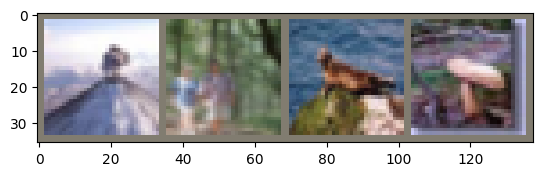

GroundTruth:	 49	33	72	51
Size		Image 1	Image 2	Image 3	Image 4
128		55	33	55	51


In [9]:
import time
from datetime import timedelta

total_start_time = time.time()
epoch_times = []

best_acc = 0
for epoch in range(200):
    epoch_start = time.time()
    train(epoch)
    acc = test(epoch)
    scheduler.step()
    
    epoch_time = time.time() - epoch_start
    epoch_times.append(epoch_time)

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), 'best_model_mrl_128.pth')
    print(f'Epoch time: {timedelta(seconds=int(epoch_time))}')
    print('-' * 80)

total_time = time.time() - total_start_time
print(f'Total training time: {timedelta(seconds=int(total_time))}')
print(f'Average epoch time: {timedelta(seconds=int(sum(epoch_times)/len(epoch_times)))}')    

print(f'Best Test Accuracy: {best_acc:.2f}%')

import matplotlib.pyplot as plt
def imshow(img):
    img = img * torch.tensor([0.2675, 0.2565, 0.2761]).view(3, 1, 1) + \
          torch.tensor([0.5071, 0.4867, 0.4408]).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth:\t', '\t'.join(f'{labels[j]}' for j in range(4)))

print("Size\t\t" + "\t".join(f"Image {j+1}" for j in range(4)))
outputs = model(images[:4].to(device))
for i, n in enumerate(nesting_list):
    _, predicted = torch.max(outputs[i], 1)
    print(f"{n}\t\t" + "\t".join(f"{predicted[j].item()}" for j in range(4)))